# This notebook is used to Train LSTM networks for sentiment analysis using Keras

### Define the necessary imports

In [63]:
from keras.layers.core import Activation, Dropout, SpatialDropout1D, Dense
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

import numpy as np
import collections
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split

%matplotlib inline

### Read the data from the file to compute the maxlength and Vocab

In [38]:
# define a collection to keep 
word_freq = collections.Counter()
maxlength = 0

numrecs = 0
fsenti = open("/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/umich_sentiment_dataset/train.txt", "rb")
for line in fsenti:
    label, text = line.lower().decode(encoding='ascii', errors='ignore').split("\t")
    words = nltk.word_tokenize(text)
    if len(words) > maxlength:
        maxlength = len(words)
    for word in words:
        word_freq[word] +=1
    numrecs += 1
fsenti.close()

print("MaxLength - ", maxlength)
print("Word Frequencies - ", len(word_freq))
# print(word_freq)
print("Number of Records - ", numrecs)

MaxLength -  42
Word Frequencies -  2313
Number of Records -  7086


### Create the word2index and index2words dictionaries

In [123]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

vocab_size = min(len(word_freq), MAX_FEATURES) + 2

word2index = { x[0]:i+2 for i,x in enumerate(word_freq.most_common(MAX_FEATURES))}
word2index["UNK"] = 0
word2index["PAD"] = 1
index2word = { v:k for k,v in word2index.items()}

print(len(word2index))
print(len(index2word))
# print(word2index)
print(index2word)


2002
2002
{0: 'UNK', 1: 'PAD', 2: 'i', 3: ',', 4: '.', 5: 'the', 6: 'and', 7: '!', 8: 'harry', 9: 'vinci', 10: 'da', 11: 'brokeback', 12: 'code', 13: 'mountain', 14: 'potter', 15: '...', 16: 'love', 17: 'is', 18: 'a', 19: 'was', 20: 'mission', 21: 'impossible', 22: 'awesome', 23: 'like', 24: 'it', 25: 'to', 26: 'movie', 27: 'that', 28: "'s", 29: 'because', 30: 'sucks', 31: 'hate', 32: 'sucked', 33: 'so', 34: 'as', 35: 'my', 36: '``', 37: 'much', 38: 'of', 39: 'really', 40: 'movies', 41: 'stupid', 42: 'you', 43: 'down', 44: 'but', 45: 'we', 46: 'be', 47: 'with', 48: 'just', 49: 'one', 50: 'potter..', 51: 'know', 52: 'suck', 53: 'out', 54: '3', 55: '/', 56: 'or', 57: 'who', 58: 'am', 59: 'loved', 60: 'want', 61: 'into', 62: 'which', 63: 'right', 64: 'for', 65: 'an', 66: "n't", 67: 'this', 68: 'me', 69: ':', 70: 'are', 71: 'think', 72: 'not', 73: 'how', 74: 'if', 75: 'depressing', 76: 'people', 77: 'his', 78: 'would', 79: 'up', 80: 'reading', 81: 'why', 82: 'series', 83: 'there', 84: 'in'

### Define each of the sentences to fixed length by padding

In [124]:
X = np.empty((numrecs, MAX_SENTENCE_LENGTH))
Y = np.zeros((numrecs, ))

print(X.shape)
print(Y.shape)

fsenti = open("/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/umich_sentiment_dataset/train.txt", "rb")
i = 0
for line in fsenti:
    seq = []
    label, text = line.lower().decode(encoding='ascii', errors='ignore').split("\t")
    words = nltk.word_tokenize(text)
    for word in words:
        if word in word2index:
            seq.append(word2index[word])
        else:
            seq.append(word2index["UNK"])
    X[i] = pad_sequences([seq], maxlen=MAX_SENTENCE_LENGTH)
    Y[i] = int(label)
    i+=1

# print(X.shape)
# print(Y.shape)
# print("")    
for i in range(10):
    print(" ")
    print(X[i])
    print(" ")
    print(Y[i])

(7086, 40)
(7086,)
 
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    5.   10.    9.   12.  101.
   17.   48.   22.    4.]
 
1.0
 
[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.    67.    19.     5.   115.     0.  1934.     2.
   362.   138.   110.     3.    44.   317.   318.    23.     0.     3.
     6.    10.     9.    12.   136.   118.  1883.   343.    67.     4.]
 
1.0
 
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    2.  125.    5.   10.    9.
   12.   18.  324.    4.]
 
1.0
 
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    

In [125]:
# divide the train and test sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size=0.2)

In [126]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(5668, 40)
(1418, 40)
(5668,)
(1418,)


### Define the LSTM model before training

In [127]:
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2 ))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 40, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 305,729
Trainable params: 305,729
Non-trainable params: 0
_________________________________________________________________


### Training the model and testing it on validation set and plotting the accuracy and loss curves

In [128]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH, validation_data=(X_test, Y_test))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 8s - loss: 0.2538 - acc: 0.8940 - val_loss: 0.0887 - val_acc: 0.9732
Epoch 2/10
5668/5668 [==============================] - 8s - loss: 0.0329 - acc: 0.9906 - val_loss: 0.0443 - val_acc: 0.9852
Epoch 3/10
5668/5668 [==============================] - 8s - loss: 0.0120 - acc: 0.9963 - val_loss: 0.0501 - val_acc: 0.9824
Epoch 4/10
5668/5668 [==============================] - 8s - loss: 0.0086 - acc: 0.9981 - val_loss: 0.0456 - val_acc: 0.9831
Epoch 5/10
5668/5668 [==============================] - 8s - loss: 0.0075 - acc: 0.9984 - val_loss: 0.0439 - val_acc: 0.9866
Epoch 6/10
5668/5668 [==============================] - 8s - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0575 - val_acc: 0.9859
Epoch 7/10
5668/5668 [==============================] - 8s - loss: 0.0049 - acc: 0.9988 - val_loss: 0.0342 - val_acc: 0.9887
Epoch 8/10
5668/5668 [==============================] - 8s - loss: 0.0012 - a

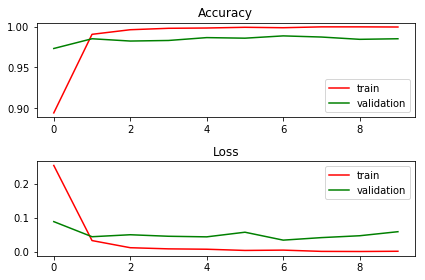

In [129]:
# plotting the results of loss and Accuracy
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['acc'], color='r', label='train')
plt.plot(history.history['val_acc'], color='g', label='validation')
plt.legend(loc='best')

plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], color='r', label='train')
plt.plot(history.history['val_loss'], color='g', label='validation')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


### Test the model on the test data and output some random predictions and labels for some samples

In [130]:
score, accuracy = model.evaluate(X_test, Y_test)
print("Score and Accuracy")
print(score, " - ", accuracy)

print(len(X_test))
print(X_test.shape)


1376/1418 [============================>.] - ETA: 0sScore and Accuracy
0.0590375114702  -  0.985190409027
1418
(1418, 40)


In [138]:
# print some sample predictions and their actual labels
print("prediction - label - sentence")
for iter in range(10):
    idx = np.random.randint(len(X_test))
    x_test = (X_test[idx].reshape(1,40)).astype(int)
#     print(X_test[idx])
#     print(x_test)
  
## This one displays an array of words in the sentence and does not form sentences    
#     sent = []
#     for i in x_test[0]:
#         if i != 0:
#             sent.append(index2word[i])

    sentence = " ".join([index2word[int(x)] for x in x_test[0].tolist() if x != 0])

    label = Y_test[idx]
    pred = model.predict(x_test)[0][0]  # as the prediction is having a shape of (1,1)
    print(pred, " - ", label, " - ", sentence)
    
#   print(pred, " - ", label, " - ", sent)

prediction - label - sentence
0.000447229  -  0.0  -  brokeback mountain was boring .
0.999999  -  1.0  -  besides myself in the da vinci code -- which , by the way , was awesome ! ) .
0.999999  -  1.0  -  i want to be here because i love harry potter , and i really want a place where people take it serious , but it is still so much fun .
0.999999  -  1.0  -  because i would like to make friends who like the same things i like , and i really like harry potter , so i thought that joining a community like this would be a good start .
0.999999  -  1.0  -  i wanted desperately to love'the da vinci code as a film .
2.07986e-05  -  0.0  -  my dad 's being stupid about brokeback mountain ...
2.81518e-06  -  0.0  -  i hate harry potter , that daniel wotshisface needs a fucking slap ...
0.00016993  -  0.0  -  i had to go to work at for stupid mission impossible 3 .
0.999999  -  1.0  -  mission impossible 3 was excellent .
0.999996  -  1.0  -  the da vinci code is awesome ! !
